### import data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, MaxNLocator

%matplotlib inline
%store -r sc_customers
%store -r sc_products
%store -r sc_categories_departments
%store -r sc_orders
%store -r sc_orders_ratio
%store -r sc_orders_demographic
%store -r sc_shipping

In [2]:
all_column_name = (
    sc_customers.columns.tolist() +
    sc_products.columns.tolist() +
    sc_categories_departments.columns.tolist() +
    sc_orders.columns.tolist() +
    sc_orders_demographic.columns.tolist() +
    sc_shipping.columns.tolist()
    )
all_column_name

['customer_id',
 'first_name',
 'last_name',
 'segment',
 'country',
 'state',
 'city',
 'street',
 'zipcode',
 'product_id',
 'product_name',
 'category_id',
 'department_id',
 'price',
 'product_image',
 'category_id',
 'category',
 'department_id',
 'department',
 'order_id',
 'transaction_id',
 'customer_id',
 'order_date',
 'payment_type',
 'product_id',
 'price',
 'quantity',
 'gross_sale',
 'discount_pct',
 'discount',
 'net_sale',
 'order_id',
 'transaction_id',
 'order_date',
 'type',
 'customer_id',
 'latitiude',
 'longitude',
 'market',
 'region',
 'country',
 'state',
 'city',
 'zipcode',
 'order_status',
 'order_id',
 'transaction_id',
 'order_date',
 'customer_id',
 'product_id',
 'shipping_date',
 'mode',
 'days_shipping_scheduled',
 'days_shipping_real',
 'delivery_status',
 'risk']

# Request 1
## Analyze the relationship between the 'days_shipping_real' and the 'risk.'

## Investigate whether orders with longer shipping durations are more likely to be at risk of late delivery.

## Additionally, break down the analysis by different product categories to see if the relationship varies across product types.

## Provide insights into potential factors contributing to late deliveries based on the shipping duration and product categories.

In [3]:
sc_shipping

,order_id,transaction_id,order_date,customer_id,product_id,shipping_date,mode,days_shipping_scheduled,days_shipping_real,delivery_status,risk
0,44371,110769,2016-10-09 16:47:00,7537,627,2016-10-10 04:47:00,Same Day,0,1,Late delivery,1
1,18065,45146,2015-09-21 16:37:00,1521,1014,2015-09-27 16:37:00,Standard Class,4,6,Late delivery,1
2,33158,82891,2016-04-29 00:22:00,5849,502,2016-05-01 00:22:00,First Class,1,2,Late delivery,1
3,73677,176992,2017-12-11 11:59:00,4848,1362,2017-12-14 11:59:00,Standard Class,4,3,Advance shipping,0
4,5834,14520,2015-03-27 03:33:00,4515,1004,2015-04-01 03:33:00,Standard Class,4,5,Late delivery,1
...,...,...,...,...,...,...,...,...,...,...,...
180514,8364,20897,2015-05-03 01:55:00,4038,1004,2015-05-08 01:55:00,Second Class,2,5,Late delivery,1
180515,14594,36501,2015-08-02 00:34:00,698,502,2015-08-07 00:34:00,Standard Class,4,5,Late delivery,1
180516,38897,97110,2016-07-21 19:00:00,290,403,2016-07-24 19:00:00,Second Class,2,3,Late delivery,1
180517,66417,166028,2017-08-27 12:28:00,11978,957,2017-08-30 12:28:00,Standard Class,4,3,Advance shipping,0


#### what does risk mean? risk is defined by whether or not a delivery was late. 1= late and 0 = not late

In [23]:
sc_shipping['risk'].value_counts()[1]

98977

In [24]:
sc_shipping['delivery_status'].value_counts()['Late delivery']

98977

In [37]:
sc_shipping[(sc_shipping['delivery_status'] == 'Late delivery') & (sc_shipping['risk'] == 1)]['risk'].value_counts()

1    98977
Name: risk, dtype: int64

#### aggregate shipments by delivery status

In [5]:
sc_shipping['delivery_status'].drop_duplicates()

0         Late delivery
3      Advance shipping
11     Shipping on time
15    Shipping canceled
Name: delivery_status, dtype: object

In [6]:
shipping_merge = sc_shipping.pivot_table(index='days_shipping_real', columns='delivery_status', aggfunc='size', fill_value=0).reset_index()
shipping_merge.columns = ['days_shipping_real', 'n_advanced', 'n_cancelled', 'n_late', 'n_on_time']
shipping_merge

,days_shipping_real,n_advanced,n_cancelled,n_late,n_on_time
0,0,0,0,241,4839
1,1,0,4454,203,0
2,2,20873,26513,2413,6819
3,3,20719,6759,1287,0
4,4,0,6759,1216,20538
5,5,0,27003,1160,0
6,6,0,27489,1234,0


In [7]:
total = sc_shipping.groupby('days_shipping_real')['delivery_status'].count().reset_index(name='total')
total

,days_shipping_real,total
0,0,5080
1,1,4657
2,2,56618
3,3,28765
4,4,28513
5,5,28163
6,6,28723


In [8]:
shipping_merge = shipping_merge.merge(total, on='days_shipping_real')

In [9]:
shipping_merge = shipping_merge[['days_shipping_real', 'total', 'n_advanced', 'n_on_time', 'n_late', 'n_cancelled']]
shipping_merge

,days_shipping_real,total,n_advanced,n_on_time,n_late,n_cancelled
0,0,5080,0,4839,241,0
1,1,4657,0,0,203,4454
2,2,56618,20873,6819,2413,26513
3,3,28765,20719,0,1287,6759
4,4,28513,0,20538,1216,6759
5,5,28163,0,0,1160,27003
6,6,28723,0,0,1234,27489


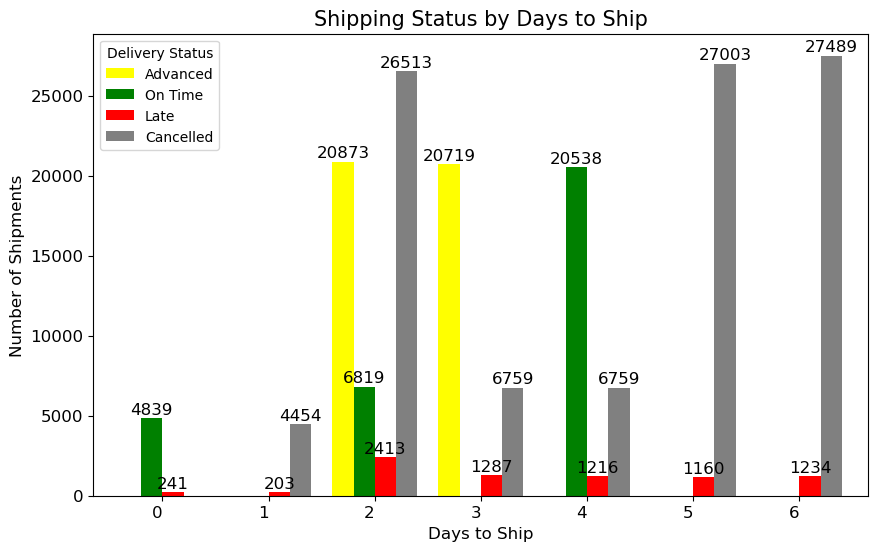

In [89]:
ax = shipping_merge.drop('total', axis=1).plot(kind='bar', x='days_shipping_real', stacked=False, figsize=(10, 6), width=0.8, color=['yellow', 'green', 'red', 'grey'])

plt.title('Shipping Status by Days to Ship', fontsize=15)
plt.xlabel('Days to Ship', fontsize=12)
plt.ylabel('Number of Shipments', fontsize=12)
plt.legend(title='Delivery Status', labels=['Advanced', 'On Time', 'Late', 'Cancelled'], title_fontsize=10, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=360, horizontalalignment='right', fontsize=12)
plt.yticks(fontsize=12)

for p in ax.patches:
    height = p.get_height()
    if height != 0:
        ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 6), textcoords='offset points', fontsize=12)

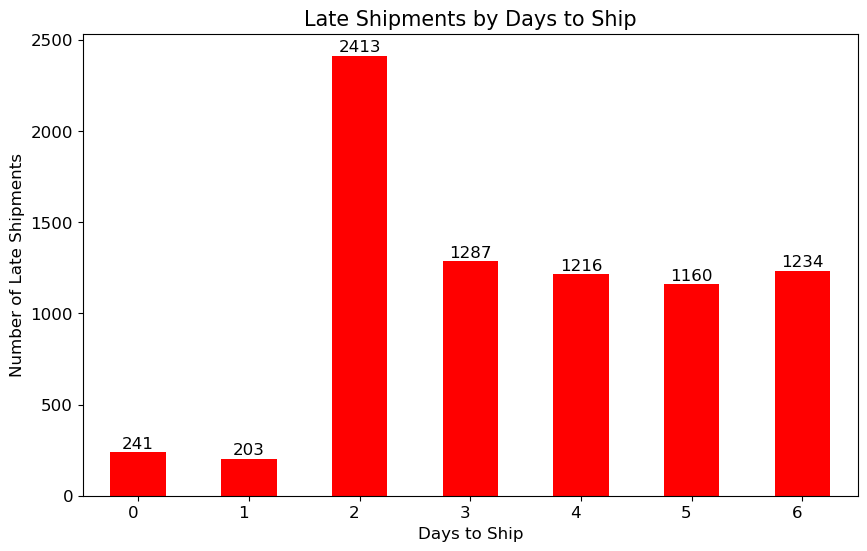

In [90]:
ax = shipping_merge['n_late'].plot(kind='bar', x='days_shipping_real', stacked=False, figsize=(10, 6), color='red')

plt.title('Late Shipments by Days to Ship', fontsize=15)
plt.xlabel('Days to Ship', fontsize=12)
plt.ylabel('Number of Late Shipments', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=360, horizontalalignment='right', fontsize=12)
plt.yticks(fontsize=12)

for p in ax.patches:
    height = p.get_height()
    if height != 0:
        ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 6), textcoords='offset points', fontsize=12)

In [116]:
shipping_merge.drop('total', axis=1)

,days_shipping_real,n_advanced,n_on_time,n_late,n_cancelled
0,0,0,4839,241,0
1,1,0,0,203,4454
2,2,20873,6819,2413,26513
3,3,20719,0,1287,6759
4,4,0,20538,1216,6759
5,5,0,0,1160,27003
6,6,0,0,1234,27489


In [163]:
shipping_melt = pd.melt(shipping_merge, id_vars=['days_shipping_real'], var_name='delivery_status', value_name='value')
shipping_pie = shipping_melt.pivot(index='delivery_status', columns='days_shipping_real', values='value').reset_index().rename_axis(columns=None)

In [168]:
shipping_pie = shipping_pie.rename(columns={0:'0_days_to_ship', 1:'1_days_to_ship', 2:'2_days_to_ship', 3:'3_days_to_ship', 4:'4_days_to_ship', 5:'5_days_to_ship', 6:'6_days_to_ship'})
shipping_pie

,delivery_status,0_days_to_ship,1_days_to_ship,2_days_to_ship,3_days_to_ship,4_days_to_ship,5_days_to_ship,6_days_to_ship
0,n_advanced,0,0,20873,20719,0,0,0
1,n_cancelled,0,4454,26513,6759,6759,27003,27489
2,n_late,241,203,2413,1287,1216,1160,1234
3,n_on_time,4839,0,6819,0,20538,0,0
4,total,5080,4657,56618,28765,28513,28163,28723


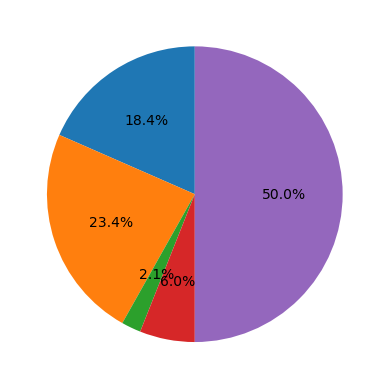

In [169]:
plt.pie(shipping_pie['2_days_to_ship'], autopct='%1.1f%%', startangle=90)



plt.show()


#### A correlation coefficient of 0.401415 indicates a positive correlation between two variables, but the strength of the correlation is moderate.

In [93]:
sc_shipping[['days_shipping_real', 'risk']].corr()

,days_shipping_real,risk
days_shipping_real,1.000000,0.401415
risk,0.401415,1.000000


In [ ]:
import matplotlib.pyplot as plt

# Example data
days_to_ship = [0, 1, 2, 3, 4, 5, 6]
advanced = [0, 0, 20873, 20719, 0, 0, 0]
on_time = [4839, 0, 6819, 0, 20538, 0, 0]
late = [241, 203, 2413, 1287, 1216, 1160, 1234]
cancelled = [0, 4454, 26513, 6759, 6759, 27003, 27489]

# Create a DataFrame
import pandas as pd
data = {'days_shipping_real': days_to_ship, 'Advanced': advanced, 'On Time': on_time, 'Late': late, 'Cancelled': cancelled}
shipping_merge = pd.DataFrame(data)

# Set custom colors
colors = ['blue', 'green', 'yellow', 'red']

# Plot the bar graph
ax = shipping_merge.drop('total', axis=1).plot(
    kind='bar', x='days_shipping_real', stacked=True, colormap='viridis', figsize=(10, 6), width=0.8, color=colors
)

# Customize the legend
legend_colors = {'Advanced': 'blue', 'On Time': 'green', 'Late': 'yellow', 'Cancelled': 'red'}
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors.values()
]
plt.legend(handles, legend_colors.keys(), title='Delivery Status', loc='upper left')

# Add labels and title
plt.title('Shipping Status by Days to Shipping')
plt.xlabel('Days to Ship')
plt.ylabel('Number of Orders')

# Customize x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Annotate the bars with values
for p in ax.patches:
    height = p.get_height()
    if height != 0:
        ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.show()


In [ ]:
shipping_merge['pct_advanced'] = (shipping_merge['n_advanced'] / shipping_merge['total'] * 100).round(2)
shipping_merge['pct_on_time'] = (shipping_merge['n_on_time'] / shipping_merge['total'] * 100).round(2)
shipping_merge['pct_late'] = (shipping_merge['n_late'] / shipping_merge['total'] * 100).round(2)
shipping_merge['pct_cancelled'] = (shipping_merge['n_cancelled'] / shipping_merge['total'] * 100).round(2)
shipping_merge = shipping_merge[['days_shipping_real', 'total', 'n_advanced', 'pct_advanced', 'n_on_time', 'pct_on_time', 'n_late', 'pct_late', 'n_cancelled', 'pct_cancelled']]

In [ ]:
xxx

In [ ]:
ax = shipping_merge.drop('total', axis=1).plot(kind='bar', stacked=False, colormap='PuOr', figsize=(10, 6))

plt.title('Shipping Status by Days to Shipping')
plt.xlabel('Days to Ship')
plt.ylabel('Number of Orders')

legend_colors = ['blue', 'green', 'orange', 'red', 'purple']
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors]

plt.legend(title='Delivery Status', labels=['Advanced', 'On Time', 'Late', 'Cancelled'], handles=handles)

In [ ]:
ax = shipping_merge.drop('total', axis=1).plot(kind='bar', stacked=False, figsize=(10, 6))

plt.title('Shipping Status by Days to Shipping')
plt.xlabel('Days to Ship')
plt.ylabel('Number of Orders')

legend_colors = ['blue', 'green', 'red', 'black']
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors]

plt.legend(title='Delivery Status', labels=['Advanced', 'On Time', 'Late', 'Cancelled'], handles=handles)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame with the provided data
data = {
    'days_shipping_real': [0, 1, 2, 3, 4, 5, 6],
    'total': [5080, 4657, 56618, 28765, 28513, 28163, 28723],
    'n_advanced': [0, 0, 20873, 20719, 0, 0, 0],
    'n_on_time': [4839, 0, 6819, 0, 20538, 0, 0],
    'n_late': [241, 203, 2413, 1287, 1216, 1160, 1234],
    'n_cancelled': [0, 4454, 26513, 6759, 6759, 27003, 27489]
}

df = pd.DataFrame(data)

# Set the 'days_shipping_real' column as the index for plotting
df.set_index('days_shipping_real', inplace=True)

# Plot the data using a grouped bar plot with custom colors
ax = df.plot(kind='bar', colormap=['blue', 'green', 'orange', 'red', 'purple'], figsize=(10, 6))

# Add labels and title
plt.xlabel('Days to Shipping')
plt.ylabel('Count')
plt.title('Shipping Status by Days to Shipping')

# Custom legend with specific colors
legend_labels = ['Total', 'Advanced', 'On Time', 'Late', 'Cancelled']
legend_colors = ['blue', 'green', 'orange', 'red', 'purple']
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors]
ax.legend(handles=handles, labels=legend_labels, title='Status', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()
